In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4
use_precise_transform = False

## Let's load the data files

In [5]:
# define the particle data group which we want to run the algorithms on
pdg = 211

# get the respective datasets locations
data_dir = os.path.join('..', '..', '..', 'data')
root_dirs = {
    'ideal':
        os.path.join(data_dir, 'pdg{}'.format(pdg), 'pdg{}-n25-0.5to10GeV-0.5eta'.format(pdg)),
    'mat':
        os.path.join(data_dir, 'pdg{}'.format(pdg),
                     'pdg{}-n25-0.5to10GeV-0.5eta-with-material-effects'.format(pdg)),
    'odd-bfield':
        os.path.join(data_dir, 'pdg{}'.format(pdg),
                     'pdg{}-n25-0.5to10GeV-0.5eta-non-homogenous-magnetic-field'.format(pdg)),
    'mat-odd-bfield':
        os.path.join(data_dir, 'pdg{}'.format(pdg),
                     'pdg{}-n25-0.5to10GeV-0.5eta-with-material-effects-non-' \
                     'homogenous-magnetic-field'.format(pdg))
}


# read the hits files and dataset
hit_files = {
    _type: sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
    for _type, root_dir in root_dirs.items()
}
hit_dfs = {
    _type: [pd.read_csv(os.path.join(root_dirs[_type], file), dtype={'particle_id':str, 'geometry_id': str})
            for file in files]
    for _type, files in hit_files.items()
}

# read the initial files and dataset
initial_files = {
    _type: sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
    for _type, root_dir in root_dirs.items()
}
initial_dfs = {
    _type: [pd.read_csv(os.path.join(root_dirs[_type], file), dtype={'particle_id':str, 'geometry_id': str})
            for file in files]
    for _type, files in initial_files.items()
}

# read the final files and dataset
final_files = {
    _type: sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
    for _type, root_dir in root_dirs.items()
}
final_dfs = {
    _type: [pd.read_csv(os.path.join(root_dirs[_type], file), dtype={'particle_id':str, 'geometry_id': str})
            for file in files]
    for _type, files in final_files.items()
}

## Let's pick an event at randrom from every simulation

In [6]:
num_events = 100
random.seed(682021)

# pick an event randomly for each case
random_event = random.choice(range(0, num_events))
ideal_df = hit_dfs['ideal'][random_event]
ideal_df['weight'] = 1
ideal_df['r'] = np.sqrt(np.square(ideal_df['tx']) + np.square(ideal_df['ty']))
ideal_df['phi'] = np.arctan2(ideal_df['ty'], ideal_df['tx'])
ideal_df['xy_track'] = ideal_df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
ideal_df['rz_track'] = ideal_df[['r','tz']].apply(lambda pair: (-pair[0], pair[1]), 1)
print(f"Event chosen for the ideal simulation:\t\t\t\t\t\t{hit_files['ideal'][random_event]}")

random_event = random.choice(range(0, num_events))
mat_df = hit_dfs['mat'][random_event]
mat_df['weight'] = 1
mat_df['r'] = np.sqrt(np.square(mat_df['tx']) + np.square(mat_df['ty']))
mat_df['phi'] = np.arctan2(mat_df['ty'], mat_df['tx'])
mat_df['xy_track'] = mat_df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
mat_df['rz_track'] = mat_df[['r','tz']].apply(lambda pair: (-pair[0], pair[1]), 1)
print(f"Event chosen for the simulation with material effect:\t\t\t\t{hit_files['mat'][random_event]}")

random_event = random.choice(range(0, num_events))
odd_bfield_df = hit_dfs['odd-bfield'][random_event]
odd_bfield_df['weight'] = 1
odd_bfield_df['r'] = np.sqrt(np.square(odd_bfield_df['tx']) + np.square(odd_bfield_df['ty']))
odd_bfield_df['phi'] = np.arctan2(odd_bfield_df['ty'], odd_bfield_df['tx'])
odd_bfield_df['xy_track'] = odd_bfield_df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
odd_bfield_df['rz_track'] = odd_bfield_df[['r','tz']].apply(lambda pair: (-pair[0], pair[1]), 1)
print(f"Event chosen for the simulation with non-homogenous B:\t\t\t\t"
      f"{hit_files['odd-bfield'][random_event]}")

random_event = random.choice(range(0, num_events))
mat_odd_bfield_df = hit_dfs['mat-odd-bfield'][random_event]
mat_odd_bfield_df['weight'] = 1
mat_odd_bfield_df['r'] = np.sqrt(np.square(mat_odd_bfield_df['tx']) + np.square(mat_odd_bfield_df['ty']))
mat_odd_bfield_df['phi'] = np.arctan2(mat_odd_bfield_df['ty'], mat_odd_bfield_df['tx'])
mat_odd_bfield_df['xy_track'] = mat_odd_bfield_df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
mat_odd_bfield_df['rz_track'] = mat_odd_bfield_df[['r','tz']].apply(lambda pair: (-pair[0], pair[1]), 1)
print(f"Event chosen for the simulation with material effect and non-homogenous B:\t"
      f"{hit_files['mat-odd-bfield'][random_event]}")

Event chosen for the ideal simulation:						event000000074-hits.csv
Event chosen for the simulation with material effect:				event000000017-hits.csv
Event chosen for the simulation with non-homogenous B:				event000000045-hits.csv
Event chosen for the simulation with material effect and non-homogenous B:	event000000003-hits.csv


## We will run the Hough Transform on the Ideal dataset and remove the duplicates from it

In [7]:
from notebook2_utils import compute_qpt, compute_b, Hough2d_pipeline, remove_found_hits
from metrics import efficiency_rate, fake_rate, duplicate_rate

In [8]:
xy_hyperparams = {
    'bin-size': (0.005, 0.1),
    'xrange': (-np.pi, np.pi),
    'yrange': (-1000, 1000),
    'minimum-hits-per-bin': 10,
    'A': A,
    'use-precise-transform': False
}

rz_hyperparams = {
    'bin-size': (0.04, 10),
    'xrange': (-0.75, 0.75),
    'yrange': (-500, 500),
    'minimum-hits-per-bin': 12
}

In [9]:
accumulator, xy_est = Hough2d_pipeline(list(ideal_df['xy_track']), xy_hyperparams, compute_qpt)

ideal_df['track'] = ideal_df['xy_track']
xy_eff = efficiency_rate(xy_est.values(), ideal_df)
xy_fake = fake_rate(xy_est.values(), ideal_df)
xy_dup = duplicate_rate(xy_est.values(), ideal_df)

print('xy Transform statistics:\n')
print(f'\tEfficiency rate: {xy_eff:.2f}')
print(f'\tFake rate: {xy_fake:.2f}')
print(f'\tDuplicate rate: {xy_dup:.2f}')

xy Transform statistics:

	Efficiency rate: 0.88
	Fake rate: 0.47
	Duplicate rate: 0.89


In [10]:
from notebook2_utils import get_roi_accumulator, plot_heatmap

roi_x = xy_hyperparams['xrange']
roi_y = xy_hyperparams['yrange']

roi_x = (-3.07, -2.8)
roi_y = (-1.11, 0.4)

rois = (roi_x, roi_y)
roi_accumulator_orig = get_roi_accumulator(accumulator, xy_hyperparams, rois)

roi_accumulator = roi_accumulator_orig.copy()
roi_accumulator.shape

(54, 15)

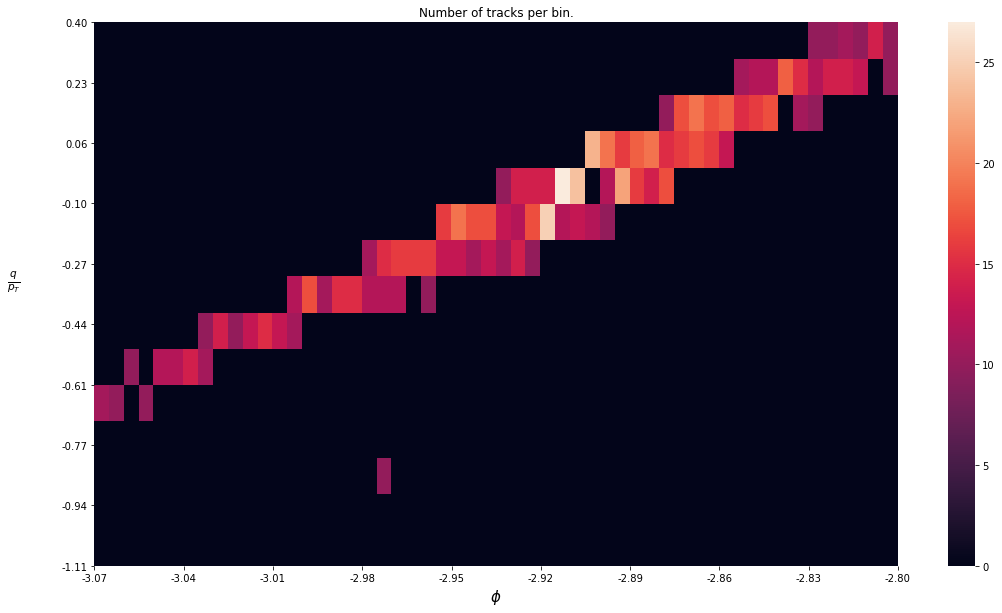

In [11]:
indices_below_thresh = roi_accumulator < xy_hyperparams['minimum-hits-per-bin']
roi_accumulator[indices_below_thresh] = 0
plot_heatmap(roi_accumulator, rois)

# Baseline solution: Identify peaks in the accumulator and aggregate them

In [12]:
def tracks_are_close(track1, track2, thresholds):
    """ Returns true if the two given track are close, up to a threshold value. """
    return abs(track1[0] - track2[0]) <= thresholds[0] and abs(track1[1] - track2[1]) <= thresholds[1]
    
def common_hits_percentage(hits1, hits2):
    """ Returns the percentage of common hits that two estimated tracks have. """
    hits1_set = set(hits1)
    hits2_set = set(hits2)
    return len(hits1_set & hits2_set) / len(hits1_set | hits2_set)

In [13]:
tracks = list(xy_est.keys())
new_est = {}
duplicates = set()

threshold_x = 2500 * xy_hyperparams['bin-size'][0]
threshold_y = 1000 * xy_hyperparams['bin-size'][1]
thresholds = (threshold_x, threshold_y)

# scan all tracks
for idx, track1 in enumerate(tracks):
    
    # if the current track has already been marked as a duplicate, proceed
    if track1 in duplicates:
        continue
        
    # else, scan all the tracks after in search of duplicates, in order to resolve the remaining track
    remaining_track = track1
    for track2 in tracks[idx:]:
        
        hits1, hits2 = xy_est[remaining_track], xy_est[track2]
        if tracks_are_close(remaining_track, track2, thresholds) and \
            common_hits_percentage(hits1, hits2) > 0.2:
            
            # the remaining track becomes the one with the most hits
            duplicates.add(track2)
            if len(hits1) < len(hits2):
                remaining_track = track2
                
    # update the new estimations dictionary
    new_est[remaining_track] = xy_est[remaining_track]

In [14]:
ideal_df['track'] = ideal_df['xy_track']
xy_eff_dup_rem = efficiency_rate(new_est.values(), ideal_df)
xy_fake_dup_rem = fake_rate(new_est.values(), ideal_df)
xy_dup_dup_rem = duplicate_rate(new_est.values(), ideal_df)

print('xy Transform (Duplicate Removal 1) statistics:\n')
print(f'\tEfficiency rate: {xy_eff_dup_rem:.2f}')
print(f'\tFake rate: {xy_fake_dup_rem:.2f}')
print(f'\tDuplicate rate: {xy_dup_dup_rem:.2f}')

xy Transform (Duplicate Removal 1) statistics:

	Efficiency rate: 0.80
	Fake rate: 0.04
	Duplicate rate: 0.20


In [15]:
tracks = list(xy_est.keys())
new_est = {}
duplicates = set()

threshold_x = 2500 * xy_hyperparams['bin-size'][0]
threshold_y = 1000 * xy_hyperparams['bin-size'][1]
thresholds = (threshold_x, threshold_y)

# scan all tracks
for idx, track1 in enumerate(tracks):
    
    # if the current track has already been marked as a duplicate, proceed
    if track1 in duplicates:
        continue
        
    # else, scan all the tracks after in search of duplicates, in order to resolve the remaining track
    remaining_track = track1
    duplicates_for_current_track = set()
    duplicates_for_current_track.add(track1)
    for track2 in tracks[idx:]:
        
        for track11 in duplicates_for_current_track:
            
            hits1, hits2 = xy_est[track11], xy_est[track2]
            
            if tracks_are_close(track11, track2, thresholds) and \
                common_hits_percentage(hits1, hits2) > 0.15:

                # the remaining track becomes the one with the most hits
                duplicates.add(track2)
                duplicates_for_current_track.add(track2)
                if len(hits1) < len(hits2):
                    remaining_track = track2
                break
                
    # update the new estimations dictionary
    new_est[remaining_track] = xy_est[remaining_track]
        

In [16]:
ideal_df['track'] = ideal_df['xy_track']
xy_eff_dup_rem = efficiency_rate(new_est.values(), ideal_df)
xy_fake_dup_rem = fake_rate(new_est.values(), ideal_df)
xy_dup_dup_rem = duplicate_rate(new_est.values(), ideal_df)

print('xy Transform (Duplicate Removal 2) statistics:\n')
print(f'\tEfficiency rate: {xy_eff_dup_rem:.2f}')
print(f'\tFake rate: {xy_fake_dup_rem:.2f}')
print(f'\tDuplicate rate: {xy_dup_dup_rem:.2f}')

xy Transform (Duplicate Removal 2) statistics:

	Efficiency rate: 0.60
	Fake rate: 0.06
	Duplicate rate: 0.06


# Stackoverflow solutions (that need testing)

In [17]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

In [18]:
def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2, 2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image == 0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

In [19]:
f = detect_peaks(roi_accumulator)

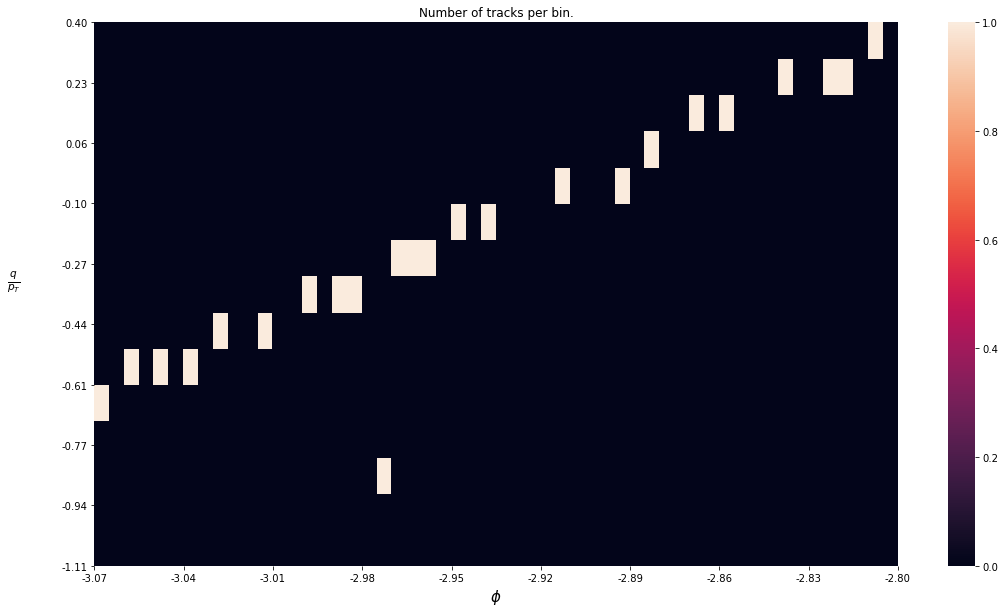

In [20]:
plot_heatmap(f, rois)

In [21]:
! pip3 install opencv-python

In [22]:
! pip3 install findpeaks

In [23]:
from findpeaks import findpeaks

# Initialize
fp = findpeaks(method='mask')

In [24]:
# Fit
fp.fit(roi_accumulator)

[findpeaks] >Finding peaks in 2d-array using mask method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Warning: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using the mask method with limit=0.
[findpeaks] >Fin.


{'Xraw': array([[ 0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 11., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.

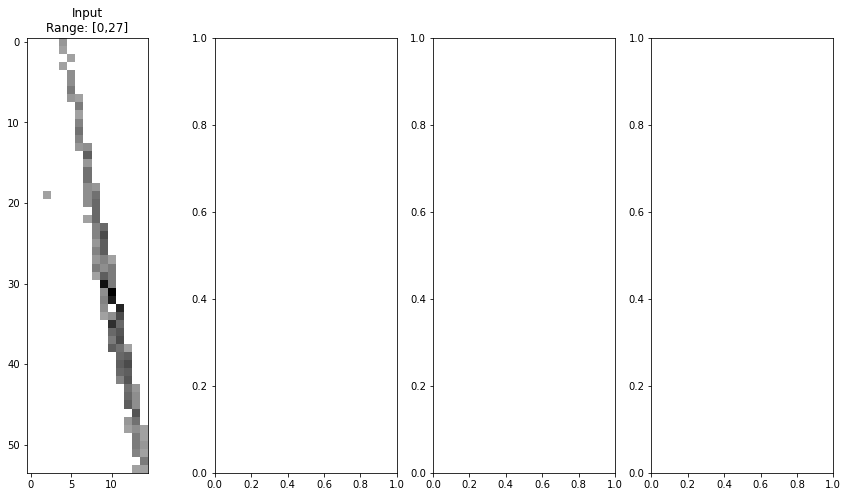

[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Warning: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].


In [25]:
# Plot the pre-processing steps
fp.plot_preprocessing()

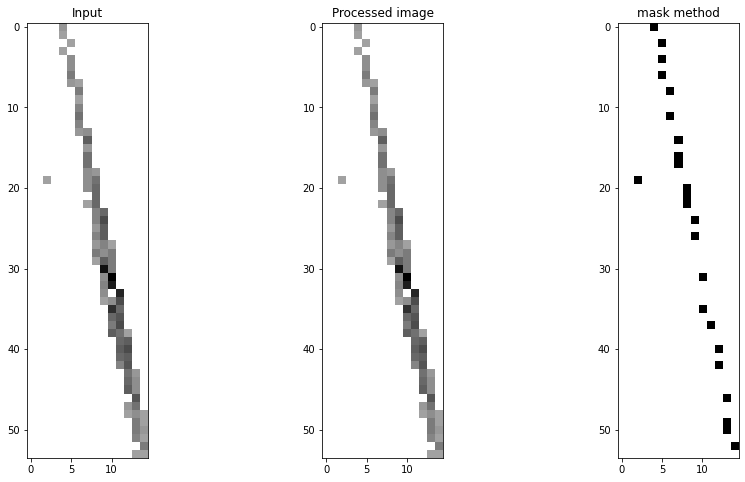

(<AxesSubplot:title={'center':'Input'}>,
 <AxesSubplot:title={'center':'Processed image'}>,
 <AxesSubplot:title={'center':'mask method'}>)

In [26]:
# Plot all
fp.plot()

In [27]:
# Initialize
fp = findpeaks(method='topology')

In [28]:
# Fit
r = fp.fit(roi_accumulator)

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >Warning: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.


810it [00:00, 116716.58it/s]

[findpeaks] >Fin.


In [29]:
for key, val in r.items():
    print(f'key {key} -> type: {type(val)}')

key Xraw -> type: <class 'numpy.ndarray'>
key Xproc -> type: <class 'numpy.ndarray'>
key Xdetect -> type: <class 'numpy.ndarray'>
key Xranked -> type: <class 'numpy.ndarray'>
key persistence -> type: <class 'pandas.core.frame.DataFrame'>
key peak -> type: <class 'numpy.ndarray'>
key valley -> type: <class 'list'>
key groups0 -> type: <class 'list'>


In [30]:
r['peak'].shape

(17, 2)

In [31]:
r['peak']

array([[  0,   0],
       [  0, 103],
       [  4, 113],
       [  6, 132],
       [ 11, 141],
       [ 14, 160],
       [ 16, 141],
       [ 19,  94],
       [ 20, 151],
       [ 24, 179],
       [ 31, 255],
       [ 35, 207],
       [ 37, 179],
       [ 40, 179],
       [ 42, 170],
       [ 46, 170],
       [ 49, 132]])